In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from tqdm import tqdm
import joblib
import shap

# Load and Clean Data

In [5]:
matches = pd.read_csv('matches_1930_2022_post_feat_engineering.csv')
test = matches[matches['Year'] == 2022]
y_test_gs = []
gs = test[test['Stage'].str.contains('Group')]
for index, i in enumerate(gs['Home Team Goals'].tolist()):
    at = gs['Away Team Goals'].tolist()[index]
    if i > at:
        y_test_gs.append(0)
    elif i == at:
        y_test_gs.append(1)
    else:
        y_test_gs.append(2)
        
ko = test[~test['Stage'].str.contains('Group')]
y_test_ko = []
for index, i in enumerate(ko['Home Team Goals'].tolist()):
    at = ko['Away Team Goals'].tolist()[index]
    if i > at:
        y_test_ko.append(0)
    elif at < i:
        y_test_ko.append(1)
    else:
        ht = ko['Home Team Name'].tolist()[index]
        if ht in ko['Win conditions'].tolist()[index]:
            y_test_ko.append(0)
        else:
            y_test_ko.append(1)
test.shape

(64, 113)

# Load Models

In [6]:
#Load models here
group_stage_model = joblib.load('Group_Stage_model_full_opt.pkl')
print('Group Stage Model:', group_stage_model)
print()
ko_stage_model = joblib.load('KO_round_model_full_opt.pkl')
print('KO Model:', ko_stage_model)

Group Stage Model: GradientBoostingClassifier(ccp_alpha=0.0004, max_features=9, random_state=88)

KO Model: GradientBoostingClassifier(ccp_alpha=0.00030000000000000003, max_features=5,
                           random_state=88)


# Prepare Tournament Simulator

In [7]:
# Create colonization dictionary
colonizer_dict = {}
colonizer_dict['Belgium'] = ['Zaire']
colonizer_dict['England'] = ['Australia','Canada','Egypt','Ghana','Iran','Iraq','Ireland','Israel','Jamaica','New Zealand','Nigeria','Nortern Ireland','Qatar','Scotland','South Africa','Trinidad and Tobago','United Arab Emirates','United States','Wales']
colonizer_dict['France'] = ['Algeria','Cameroon','Haiti','Ivory Coast','Morocco','Senegal','Togo','Tunisia']
colonizer_dict['Netherlands'] = ['Dutch East Indies']
colonizer_dict['Portugal'] = ['Angola','Brazil']
colonizer_dict['Spain'] = ['Argentina','Bolivia','Chile','Colombia','Costa Rica','Cuba','Ecuador','El Salvador','Honduras','Mexico','Panama','Paraguay','Peru','Uruguay']

In [8]:
# Helper function that returns a row vector for a KO stage match given 2 teams and the stage at which they play
def getRowVector(home_team, away_team, stage):
    filt_ht = test[test['Home Team Name'] == home_team]
    drop = []
    for i in filt_ht.columns:
        if '_home' not in i:
            drop.append(i)
    filt_ht = filt_ht.drop(columns=drop)
    filt_ht = filt_ht.head(1)
    filt_ht = filt_ht.reset_index(drop=True)
    filt_at = test[test['Away Team Name'] == away_team]
    drop = []
    for i in filt_at.columns:
        if '_away' not in i:
            drop.append(i)
    filt_at = filt_at.drop(columns=drop)
    filt_at = filt_at.head(1)
    filt_at = filt_at.reset_index(drop=True)
    big = pd.concat([filt_ht, filt_at], axis=1)
    big['GroupStage'] = [0]
    if stage == 'R16':
        big['R16'] = [1]
        big['QF'] = [0]
        big['SF'] = [0]
        big['F'] = [0]
        big['PO3'] = [0]
    elif stage == 'QF':
        big['R16'] = [0]
        big['QF'] = [1]
        big['SF'] = [0]
        big['F'] = [0]
        big['PO3'] = [0]
    elif stage == 'SF':
        big['R16'] = [0]
        big['QF'] = [0]
        big['SF'] = [1]
        big['F'] = [0]
        big['PO3'] = [0]
    elif stage == 'F':
        big['R16'] = [0]
        big['QF'] = [0]
        big['SF'] = [0]
        big['F'] = [1]
        big['PO3'] = [0]
    elif stage == 'PO3':
        big['R16'] = [0]
        big['QF'] = [0]
        big['SF'] = [0]
        big['F'] = [0]
        big['PO3'] = [1]
    if home_team in colonizer_dict.keys() and away_team in colonizer_dict[home_team]:
        big['Home_Colonized_Away'] = [1]
        big['Away_Colonized_Home'] = [0]
    elif away_team in colonizer_dict.keys() and home_team in colonizer_dict[away_team]:
        big['Home_Colonized_Away'] = [0]
        big['Away_Colonized_Home'] = [1]
    else:
        big['Home_Colonized_Away'] = [0]
        big['Away_Colonized_Home'] = [0]
    return big[ko_stage_model.feature_names]

In [9]:
# Helper function that applies the KO stage model model to an input row vector
def testGame(game_vec, model=ko_stage_model):
    game_vec = game_vec[ko_stage_model.feature_names]
    y_prob = model.predict_proba(game_vec)[0]
    result = np.random.choice(['Home Win', 'Away Win'], p=y_prob)
    return result

In [10]:
# Get only group stage matches
test_group_stage = test[test['Stage'].str.contains('Group')]
test_group_stage.shape

(48, 113)

In [11]:
# Set X_test such that it only contains features from the group stage model
X_test = test_group_stage[group_stage_model.feature_names]
X_test.shape

(48, 54)

In [106]:
# Set number of simulations
n_simulations = 10000
# Put teams in the same groups that they were in at the tournament's start
group_stage_dict = {'Group A':['Netherlands','Senegal','Ecuador','Qatar'], 'Group B':['England','United States','Iran','Wales'], 
              'Group C':['Argentina','Poland','Saudi Arabia','Mexico'], 'Group D':['France','Australia','Tunisia','Denmark'],
              'Group E':['Japan','Spain','Germany','Costa Rica'], 'Group F':['Morocco','Croatia','Belgium','Canada'],
              'Group G':['Brazil','Switzerland','Cameroon','Serbia'],'Group H':['Portugal','South Korea','Uruguay','Ghana']}
#Initialize team result dictionaries
team_result_dict = {}
team_group_result_dict = {}
for i in test['Home Team Name'].unique():
    team_result_dict[i] = []
    team_group_result_dict[i] = []
for i in test['Away Team Name'].unique():
    team_result_dict[i] = []
    team_group_result_dict[i] = []
#Start simulation
for i in tqdm(np.arange(n_simulations)):
    #Initialize group stage performance dictionary
    team_sim_group = {}
    for x in test['Home Team Name'].unique():
        team_sim_group[x] = 0
    for x in test['Away Team Name'].unique():
        team_sim_group[x] = 0
    #Iterate through all group stage games
    for index, row in test_group_stage.iterrows():
        ht = row['Home Team Name']
        at = row['Away Team Name']
        group = row['Stage']
        row_vector = X_test.loc[index:index]
        y_prob = group_stage_model.predict_proba(row_vector)[0]
        result = np.random.choice(['Home Win', 'Draw', 'Away Win'], p=y_prob)
        if result == 'Home Win':
            team_sim_group[ht] += 3
        elif result == 'Draw':
            team_sim_group[ht] += 1
            team_sim_group[at] += 1
        else:
            team_sim_group[at] += 3
    for x in team_sim_group.keys():
        val = team_sim_group[x]
        lista = team_group_result_dict[x]
        lista.append(val)
        team_group_result_dict[x] = lista
    #Return group results (who are the top 2 teams per group?). In case of tie, select tied teams based off random choice)
    group_results = {}
    for x in group_stage_dict.keys():
        lista = group_stage_dict[x]
        dicta = {}
        for y in lista:
            dicta[y] = team_sim_group[y]
        df = pd.DataFrame()
        df['Team'] = dicta.keys()
        df['Points'] = dicta.values()
        df = df.sort_values('Points', ascending=False)
        top = df[df['Points'] == max(dicta.values())]
        if len(top) == 1:
            tup = [top['Team'].tolist()[0]]
            second = df[df['Points'] < max(dicta.values())]
            max_val = second['Points'].max()
            second = second[second['Points'] == max_val]
            if len(second) == 1:
                tup.append(second['Team'].tolist()[0])
            else:
                list(np.random.choice(second['Team'].tolist()))
                tup.append(np.random.choice(second['Team'].tolist()))
        elif len(top) > 1:
            tup = list(np.random.choice(top['Team'].tolist(), size=2, replace=False))
        group_results[x] = tup
    #For teams that did not make it out of group stage, append 'Group' result to their result dictionary
    for x in team_result_dict.keys():
        isin = False
        for y in group_results.keys():
            if x in group_results[y]:
                isin=True
                break
        if not isin:
            lista = team_result_dict[x]
            lista.append('Group')
            team_result_dict[x] = lista
    #Start Round of 16
    r16_dict = {}
    ##Game 1
    ht = group_results['Group A'][0]
    at = group_results['Group B'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 1'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 1'] = at
    ##Game 2
    ht = group_results['Group C'][0]
    at = group_results['Group D'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 2'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 2'] = at
    ##Game 3
    ht = group_results['Group E'][0]
    at = group_results['Group F'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 3'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 3'] = at
    ##Game 4
    ht = group_results['Group G'][0]
    at = group_results['Group H'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 4'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 4'] = at
    ##Game 5
    ht = group_results['Group B'][0]
    at = group_results['Group A'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 5'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 5'] = at
    ##Game 6
    ht = group_results['Group D'][0]
    at = group_results['Group C'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 6'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 6'] = at
    ##Game 7
    ht = group_results['Group F'][0]
    at = group_results['Group E'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 7'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 7'] = at
    ##Game 8
    ht = group_results['Group H'][0]
    at = group_results['Group G'][1]
    game_vec = getRowVector(ht, at, 'R16')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('R16')
        team_result_dict[at] = lista
        r16_dict['Game 8'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('R16')
        team_result_dict[ht] = lista
        r16_dict['Game 8'] = at
    #QF
    qf_dict = {}
    ##Game 1
    ht = r16_dict['Game 1']
    at = r16_dict['Game 2']
    game_vec = getRowVector(ht, at, 'QF')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('QF')
        team_result_dict[at] = lista
        qf_dict['Game 1'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('QF')
        team_result_dict[ht] = lista
        qf_dict['Game 1'] = at
    ##Game 2
    ht = r16_dict['Game 3']
    at = r16_dict['Game 4']
    game_vec = getRowVector(ht, at, 'QF')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('QF')
        team_result_dict[at] = lista
        qf_dict['Game 2'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('QF')
        team_result_dict[ht] = lista
        qf_dict['Game 2'] = at
    ##Game 3
    ht = r16_dict['Game 5']
    at = r16_dict['Game 6']
    game_vec = getRowVector(ht, at, 'QF')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('QF')
        team_result_dict[at] = lista
        qf_dict['Game 3'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('QF')
        team_result_dict[ht] = lista
        qf_dict['Game 3'] = at
    ##Game 4
    ht = r16_dict['Game 7']
    at = r16_dict['Game 8']
    game_vec = getRowVector(ht, at, 'QF')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[at]
        lista.append('QF')
        team_result_dict[at] = lista
        qf_dict['Game 4'] = ht
    else:
        lista = team_result_dict[ht]
        lista.append('QF')
        team_result_dict[ht] = lista
        qf_dict['Game 4'] = at
    #SF
    sf_dict = {}
    sf_dict_l = {}
    ##Game 1
    ht = qf_dict['Game 1']
    at = qf_dict['Game 2']
    game_vec = getRowVector(ht, at, 'SF')
    result = testGame(game_vec)
    if result == 'Home Win':
        sf_dict['Game 1'] = ht
        sf_dict_l['Game 1'] = at
    else:
        sf_dict['Game 1'] = at
        sf_dict_l['Game 1'] = ht
    ##Game 2
    ht = qf_dict['Game 3']
    at = qf_dict['Game 4']
    game_vec = getRowVector(ht, at, 'SF')
    result = testGame(game_vec)
    if result == 'Home Win':
        sf_dict['Game 2'] = ht
        sf_dict_l['Game 2'] = at
    else:
        sf_dict['Game 2'] = at
        sf_dict_l['Game 2'] = ht
    #PO3
    ht = sf_dict_l['Game 1']
    at = sf_dict_l['Game 2']
    game_vec = getRowVector(ht, at, 'PO3')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[ht]
        lista.append('3rd')
        team_result_dict[ht] = lista
        lista = team_result_dict[at]
        lista.append('4th')
        team_result_dict[at] = lista
    else:
        lista = team_result_dict[at]
        lista.append('3rd')
        team_result_dict[at] = lista
        lista = team_result_dict[ht]
        lista.append('4th')
        team_result_dict[ht] = lista
    #F
    ht = sf_dict['Game 1']
    at = sf_dict['Game 2']
    game_vec = getRowVector(ht, at, 'F')
    result = testGame(game_vec)
    if result == 'Home Win':
        lista = team_result_dict[ht]
        lista.append('1st')
        team_result_dict[ht] = lista
        lista = team_result_dict[at]
        lista.append('2nd')
        team_result_dict[at] = lista
    else:
        lista = team_result_dict[at]
        lista.append('1st')
        team_result_dict[at] = lista
        lista = team_result_dict[ht]
        lista.append('2nd')
        team_result_dict[ht] = lista

100%|█████████████████████████████████████| 10000/10000 [38:00<00:00,  4.38it/s]


In [107]:
# Show outcome table - this table gives us the probability of each team finishing in each stage
win = []
ru = []
third = []
fourth = []
qf = []
r16 = []
g = []
for i in team_result_dict.keys():
    lista = team_result_dict[i]
    gc = 0
    r16c = 0
    qfc = 0
    fourthc = 0
    thirdc = 0
    ruc = 0
    winc = 0
    for x in lista:
        if x == 'Group':
            gc += 1
        elif x == 'R16':
            r16c += 1
        elif x == 'QF':
            qfc += 1
        elif x == '4th':
            fourthc += 1
        elif x == '3rd':
            thirdc += 1
        elif x == '2nd':
            ruc += 1
        elif x == '1st':
            winc += 1
    win.append(winc)
    ru.append(ruc)
    third.append(thirdc)
    fourth.append(fourthc)
    qf.append(qfc)
    r16.append(r16c)
    g.append(gc)
result_df = pd.DataFrame()
result_df['Team'] = team_result_dict.keys()
result_df['Group'] = np.array(g)/n_simulations
result_df['R16'] = np.array(r16)/n_simulations
result_df['QF'] = np.array(qf)/n_simulations
result_df['4th Place'] = np.array(fourth)/n_simulations
result_df['3rd Place'] = np.array(third)/n_simulations
result_df['2nd Place'] = np.array(ru)/n_simulations
result_df['Winner'] = np.array(win)/n_simulations
result_df.sort_values('Winner', ascending=False)

,Team,Group,R16,QF,4th Place,3rd Place,2nd Place,Winner
7,France,0.2790,0.1481,0.1206,0.0371,0.0958,0.1051,0.2143
9,Germany,0.2011,0.1801,0.1392,0.0511,0.1136,0.1139,0.2010
10,Spain,0.1616,0.2133,0.1885,0.0592,0.1123,0.1247,0.1404
4,Argentina,0.1261,0.3189,0.1777,0.0569,0.1008,0.1026,0.1170
1,England,0.1964,0.2127,0.2794,0.0812,0.0889,0.0816,0.0598
17,Netherlands,0.1757,0.2450,0.2856,0.0779,0.0822,0.0765,0.0571
12,Brazil,0.1347,0.3102,0.3198,0.0568,0.0715,0.0557,0.0513
13,Portugal,0.2654,0.2576,0.2854,0.0523,0.0492,0.0561,0.0340
11,Belgium,0.2308,0.4532,0.1266,0.0517,0.0526,0.0521,0.0330
15,Uruguay,0.2077,0.3202,0.2989,0.0583,0.0475,0.0441,0.0233


In [ ]:
# Define multiclass brier score metric
def scoringMetric(y_true,y_pred):
    if type(y_true)  == list:
        y_true = np.array(y_true)
    n_classes = y_pred.shape[1]
    y_true_one_hot = np.eye(n_classes)[y_true.astype(int)]

    # Calculate the squared differences
    squared_diff = (y_true_one_hot - y_pred) ** 2

    # Calculate the mean squared difference
    score = np.mean(np.sum(squared_diff, axis=1))

    return score

In [115]:
# Create a simulation result table that shows the probabilities of each team reaching each stage of the tournament (exception: probability for group stage = 
# probability of getting KO'd in group stage)
result_df_eval['R16'] = 1 - result_df_eval['Group']
result_df_eval['QF'] = result_df_eval['QF'] + result_df_eval['SF'] + result_df_eval['F']
result_df_eval['SF'] = result_df_eval['SF'] + result_df_eval['F']
result_df_eval['Winner'] = result_df['Winner']
result_df_eval.sort_values('Winner', ascending=False)

,Team,Group,R16,QF,SF,F,Winner
7,France,0.2790,0.7210,0.5729,0.4523,0.3194,0.2143
9,Germany,0.2011,0.7989,0.6188,0.4796,0.3149,0.2010
10,Spain,0.1616,0.8384,0.6251,0.4366,0.2651,0.1404
4,Argentina,0.1261,0.8739,0.5550,0.3773,0.2196,0.1170
1,England,0.1964,0.8036,0.5909,0.3115,0.1414,0.0598
17,Netherlands,0.1757,0.8243,0.5793,0.2937,0.1336,0.0571
12,Brazil,0.1347,0.8653,0.5551,0.2353,0.1070,0.0513
13,Portugal,0.2654,0.7346,0.4770,0.1916,0.0901,0.0340
11,Belgium,0.2308,0.7692,0.3160,0.1894,0.0851,0.0330
15,Uruguay,0.2077,0.7923,0.4721,0.1732,0.0674,0.0233


# Betting

In [114]:
pass_gs_betting_odds = {'Netherlands':[-1000,0.8243,1],
                        'Senegal':[-141,0.2905,1],
                        'Ecuador':[100,0.3804,0],
                        'Qatar':[400,0.5048,0],
                        'England':[-2000,0.8036,1],
                        'United States':[100,0.5955,1],
                        'Wales':[110,0.3640,0],
                        'Iran':[300,0.2369,0],
                        'Argentina':[-1786,0.8739,1],
                        'Mexico':[-125,0.7070,0],
                        'Poland':[100,0.3186,1],
                        'Saudi Arabia':[700,0.1005,0],
                        'France':[-1786,0.7210,1],
                        'Denmark':[-333,0.6065,0],
                        'Tunisia':[100,0.2133,0],
                        'Australia':[400,0.4592,1],
                        'Spain':[-1613,0.8384,1],
                        'Germany':[-1000,0.7989,0],
                        'Japan':[330,0.2009,1],
                        'Costa Rica':[800,0.1618,0],
                        'Belgium':[-1000,0.7692,0],
                        'Croatia':[-250,0.5255,1],
                        'Morocco':[200,0.3126,1],
                        'Canada':[300,0.3927,0],
                        'Brazil':[-1613,0.8653,1],
                        'Serbia':[-110,0.2483,0],
                        'Switzerland':[-110,0.7299,1],
                        'Cameroon':[350,0.1565,0],
                        'Portugal':[-752,0.7346,1],
                        'Uruguay':[-250,0.7923,0],
                        'South Korea':[250,0.3218,1],
                        'Ghana':[275,0.1513,0]}
group_stage_dict = {'Group A':['Netherlands','Senegal','Ecuador','Qatar'], 'Group B':['England','United States','Iran','Wales'], 
              'Group C':['Argentina','Poland','Saudi Arabia','Mexico'], 'Group D':['France','Australia','Tunisia','Denmark'],
              'Group E':['Japan','Spain','Germany','Costa Rica'], 'Group F':['Morocco','Croatia','Belgium','Canada'],
              'Group G':['Brazil','Switzerland','Cameroon','Serbia'],'Group H':['Portugal','South Korea','Uruguay','Ghana']}

In [115]:
# Group Stage
money_list = []
money = 1000
money_list.append(money)
kelly_frac = 0.25
for i in pass_gs_betting_odds.keys():
    lista = pass_gs_betting_odds[i]
    odds = lista[0]
    if odds > 0:
        b = odds/100
    else:
        b = -100/odds
    p = lista[1]
    outcome = lista[2]
    kc = p - (1-p)/b
    kc *= kelly_frac
    if kc > 0:
        print('Country:',i)
        print('Fraction:', kc)
        wager = 1000
        print('Bet Size:', wager*kc)
        if outcome:
            print('Profit:', kc*wager*b)
            money += kc*wager*b
        else:
            print('Loss:', -kc*wager)
            money -= kc*wager
        money_list.append(money)
        print('Money:', money)
        print()

Country: Qatar
Fraction: 0.09525
Bet Size: 95.25
Loss: -95.25
Money: 904.75

Country: United States
Fraction: 0.047750000000000015
Bet Size: 47.750000000000014
Profit: 47.750000000000014
Money: 952.5

Country: Mexico
Fraction: 0.08518749999999999
Bet Size: 85.18749999999999
Loss: -85.18749999999999
Money: 867.3125

Country: Australia
Fraction: 0.081
Bet Size: 81.0
Profit: 324.0
Money: 1191.3125

Country: Costa Rica
Fraction: 0.014256249999999998
Bet Size: 14.256249999999998
Loss: -14.256249999999998
Money: 1177.05625

Country: Canada
Fraction: 0.04756666666666667
Bet Size: 47.56666666666667
Loss: -47.56666666666667
Money: 1129.4895833333335

Country: Switzerland
Fraction: 0.10819749999999999
Bet Size: 108.19749999999999
Profit: 98.36136363636362
Money: 1227.8509469696971

Country: Uruguay
Fraction: 0.0682625
Bet Size: 68.2625
Loss: -68.2625
Money: 1159.588446969697

Country: South Korea
Fraction: 0.012629999999999988
Bet Size: 12.629999999999988
Profit: 31.57499999999997
Money: 1191.16

In [116]:
#R16
def predictGame(teams, stage, odds, res, money):
    game_vec = getRowVector(teams[0], teams[1], stage)
    prob = testGame2(game_vec)
    odds_f = [i/100 if i > 0 else -100/i for i in odds]
    odds_ip = [100/(100+i) if i > 0 else -i/(-1*i+100) for i in odds]
    b = odds_f[0]
    ip = odds_ip[0]
    p = prob[0]
    outcome = res[0]
    team = teams[0]
    kc = p - (1-p)/b
    kc *= kelly_frac
    if kc > 0:
        print('Country:',team)
        print('Odds:', odds[0])
        print('Odds Implied Probability:', ip)
        print('Probability:', p)
        print('Fraction:', kc)
        wager = 1000
        print('Bet Size:', wager*kc)
        if outcome:
            print('Profit:', kc*wager*b)
            money += kc*wager*b
        else:
            print('Loss:', -kc*wager)
            money -= kc*wager
        print('Money:', money)
        money_list.append(money)
    b = odds_f[1]
    ip = odds_ip[1]
    p = prob[1]
    outcome = res[1]
    team = teams[1]
    kc = p - (1-p)/b
    kc *= kelly_frac
    if kc > 0:
        print('Country:',team)
        print('Odds:', odds[1])
        print('Odds Implied Probability:', ip)
        print('Probability:', p)
        print('Fraction:', kc)
        wager = 1000
        print('Bet Size:', wager*kc)
        if outcome:
            print('Profit:', kc*wager*b)
            money += kc*wager*b
        else:
            print('Loss:', -kc*wager)
            money -= kc*wager
        print('Money:', money)
        money_list.append(money)
    print()
    return money
## Game 1
teams = ['Netherlands', 'United States']
odds = [-225, 155]
res = [1,0]
money = predictGame(teams, 'R16', odds, res, money)

## Game 2
teams = ['Argentina', 'Australia']
odds = [-2000, 800]
res = [1,0]
money = predictGame(teams, 'R16', odds, res, money)

## Game 3
teams = ['Japan', 'Croatia']
odds = [156, -190]
res = [0,1]
money = predictGame(teams, 'R16', odds, res, money)

## Game 4
teams = ['Brazil', 'South Korea']
odds = [-1000, 550]
res = [1,0]
money = predictGame(teams, 'R16', odds, res, money)

## Game 5
teams = ['England', 'Senegal']
odds = [-450, 290]
res = [1,0]
money = predictGame(teams, 'R16', odds, res, money)

## Game 6
teams = ['France', 'Poland']
odds = [-650, 475]
res = [1,0]
money = predictGame(teams, 'R16', odds, res, money)

## Game 7
teams = ['Morocco', 'Spain']
odds = [260, -375]
res = [1,0]
money = predictGame(teams, 'R16', odds, res, money)

## Game 8
teams = ['Portugal', 'Switzerland']
odds = [-250, 165]
res = [1,0]
money = predictGame(teams, 'R16', odds, res, money)

Country: Netherlands
Odds: -225
Odds Implied Probability: 0.6923076923076923
Probability: 0.9184708291973777
Fraction: 0.18375754872286934
Bet Size: 183.75754872286933
Profit: 81.67002165460859
Money: 1272.8334686243056

Country: Australia
Odds: 800
Odds Implied Probability: 0.1111111111111111
Probability: 0.21694068371835296
Fraction: 0.02976456729578677
Bet Size: 29.76456729578677
Loss: -29.76456729578677
Money: 1243.068901328519

Country: Croatia
Odds: -190
Odds Implied Probability: 0.6551724137931034
Probability: 0.6615148930136007
Fraction: 0.004598297434860482
Bet Size: 4.598297434860482
Profit: 2.4201565446634117
Money: 1245.4890578731822

Country: South Korea
Odds: 550
Odds Implied Probability: 0.15384615384615385
Probability: 0.1739396575202241
Fraction: 0.005936716994611672
Bet Size: 5.936716994611673
Loss: -5.936716994611673
Money: 1239.5523408785705

Country: England
Odds: -450
Odds Implied Probability: 0.8181818181818182
Probability: 0.8606314524851577
Fraction: 0.05836824

In [117]:
#QF
## Game 1
teams = ['Netherlands', 'Argentina']
odds = [130, -175]
res = [0,1]
money = predictGame(teams, 'QF', odds, res, money)

## Game 2
teams = ['Croatia', 'Brazil']
odds = [380, -650]
res = [1,0]
money = predictGame(teams, 'QF', odds, res, money)

## Game 3
teams = ['England', 'France']
odds = [110, -145]
res = [0,1]
money = predictGame(teams, 'QF', odds, res, money)

## Game 4
teams = ['Morocco', 'Portugal']
odds = [220, -350]
res = [1,0]
money = predictGame(teams, 'QF', odds, res, money)

Country: Netherlands
Odds: 130
Odds Implied Probability: 0.43478260869565216
Probability: 0.45436852919569615
Fraction: 0.00866300329809637
Bet Size: 8.663003298096369
Loss: -8.663003298096369
Money: 1221.768204224966

Country: Croatia
Odds: 380
Odds Implied Probability: 0.20833333333333334
Probability: 0.4635456907685416
Fraction: 0.08059337603217102
Bet Size: 80.59337603217102
Profit: 306.2548289222499
Money: 1528.0230331472158

Country: France
Odds: -145
Odds Implied Probability: 0.5918367346938775
Probability: 0.6984171993075031
Fraction: 0.06528053457584566
Bet Size: 65.28053457584566
Profit: 45.021058328169424
Money: 1573.0440914753851

Country: Morocco
Odds: 220
Odds Implied Probability: 0.3125
Probability: 0.3844736992717682
Fraction: 0.026172254280643
Bet Size: 26.172254280643
Profit: 57.5789594174146
Money: 1630.6230508927997



In [118]:
#SF
## Game 1
teams = ['Argentina', 'Croatia']
odds = [-235, 190]
res = [1,0]
money = predictGame(teams, 'SF', odds, res, money)

## Game 2
teams = ['France', 'Morocco']
odds = [-360, 275]
res = [1,0]
money = predictGame(teams, 'SF', odds, res, money)

Country: Argentina
Odds: -235
Odds Implied Probability: 0.7014925373134329
Probability: 0.7824462744714107
Fraction: 0.06779875486980644
Bet Size: 67.79875486980644
Profit: 28.850533987151678
Money: 1659.4735848799514

Country: France
Odds: -360
Odds Implied Probability: 0.782608695652174
Probability: 0.7849744090086677
Fraction: 0.002720570359967811
Bet Size: 2.720570359967811
Profit: 0.7557139888799476
Money: 1660.2292988688314



In [119]:
#F
## Game 1
teams = ['Argentina', 'France']
odds = [100, -120]
res = [1,0]
money = predictGame(teams, 'F', odds, res, money)

## PO3
teams = ['Croatia', 'Morocco']
odds = [-140, 115]
res = [1,0]
money = predictGame(teams, 'PO3', odds, res, money)

Country: France
Odds: -120
Odds Implied Probability: 0.5454545454545454
Probability: 0.6103882760341055
Fraction: 0.03571355181875803
Bet Size: 35.71355181875803
Loss: -35.71355181875803
Money: 1624.5157470500733

Country: Morocco
Odds: 115
Odds Implied Probability: 0.46511627906976744
Probability: 0.5234000484387115
Fraction: 0.027241326987658604
Bet Size: 27.241326987658603
Loss: -27.241326987658603
Money: 1597.2744200624147



In [120]:
# Turned $1000 into $2030.88 
print(f'Profit: ${round(money - 1000,2)}')
print(f'Percent Return: {100*round(money/1000 - 1, 4)}%')

Profit: $597.27
Percent Return: 59.730000000000004%


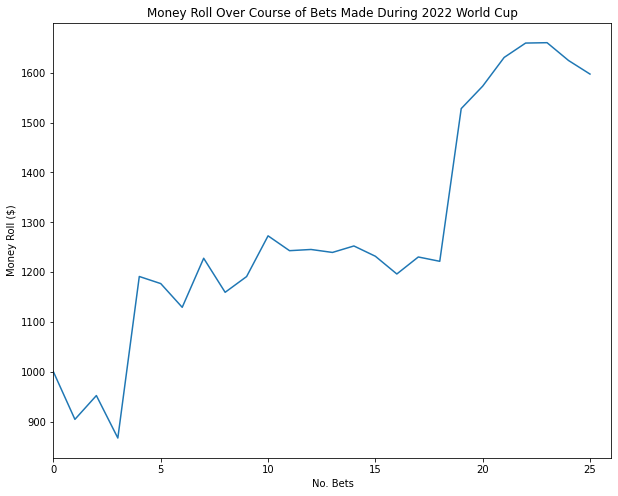

In [121]:
plt.figure(figsize=(10,8))
plt.plot(range(0, len(money_list)), money_list)
plt.xlabel('No. Bets')
plt.ylabel('Money Roll ($)')
plt.title('Money Roll Over Course of Bets Made During 2022 World Cup')
plt.xlim([0,len(money_list)]);

In [ ]:
money_list_10 = money_list.copy()

In [71]:
money_list_25 = money_list.copy()

In [88]:
money_list_50 = money_list.copy()

In [96]:
money_list_75 = money_list.copy()

In [104]:
money_list_100 = money_list.copy()

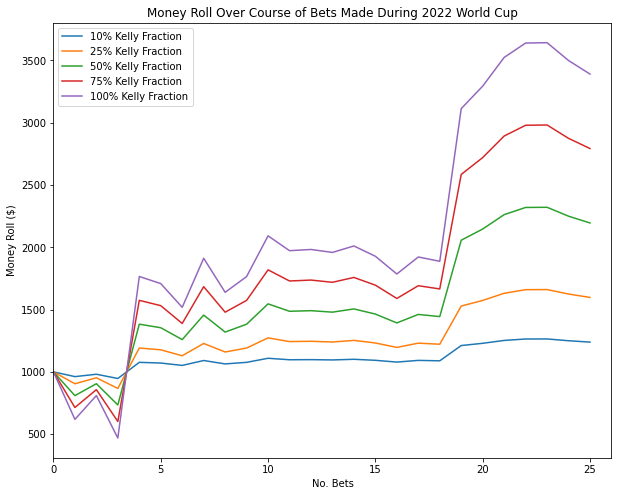

In [106]:
plt.figure(figsize=(10,8))
plt.plot(range(0, len(money_list)), money_list_10)
plt.plot(range(0, len(money_list)), money_list_25)
plt.plot(range(0, len(money_list)), money_list_50)
plt.plot(range(0, len(money_list)), money_list_75)
plt.plot(range(0, len(money_list)), money_list_100)
plt.legend(['10% Kelly Fraction', '25% Kelly Fraction', '50% Kelly Fraction', '75% Kelly Fraction', '100% Kelly Fraction'])
plt.xlabel('No. Bets')
plt.ylabel('Money Roll ($)')
plt.title('Money Roll Over Course of Bets Made During 2022 World Cup')
plt.xlim([0,len(money_list)]);